In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv('/modecraft_online_retail.csv')

<ipython-input-5-400caa7451d9>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/modecraft_online_retail.csv')


In [6]:
# Data Cleaning
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%y %H:%M')
df = df.dropna()
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

In [7]:
# Feature Engineering
df['Revenue'] = df['Quantity'] * df['UnitPrice']
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['Hour'] = df['InvoiceDate'].dt.hour
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5,6])
df['Quarter'] = df['InvoiceDate'].dt.quarter

In [11]:
# Product Health Score
product_quantity = df.groupby('StockCode')['Quantity'].sum().reset_index()
product_revenue = df.groupby('StockCode')['Revenue'].sum().reset_index()
product_summary = pd.merge(product_quantity, product_revenue, on='StockCode')

product_description = df[['StockCode', 'Description']].drop_duplicates('StockCode')
product_summary = pd.merge(product_summary, product_description, on='StockCode')

product_summary['REVENUE_PERCENTILE'] = product_summary['Revenue'].rank(pct=True)
product_summary['QUANTITY_PERCENTILE'] = product_summary['Quantity'].rank(pct=True)
product_summary['HEALTHSCORE'] = product_summary['REVENUE_PERCENTILE'] + product_summary['QUANTITY_PERCENTILE']
product_summary['RANK'] = product_summary['HEALTHSCORE'].rank(ascending=False)
product_summary = product_summary.sort_values('HEALTHSCORE', ascending=False)
product_summary = product_summary[['StockCode', 'Quantity', 'Revenue', 'Description', 'HEALTHSCORE', 'RANK']]

In [12]:
# Market Basket Analysis (Top 50 Products only)
top_50_products = df['StockCode'].value_counts().head(50).index
df_filtered = df[df['StockCode'].isin(top_50_products)]

basket_raw = df_filtered[['InvoiceNo', 'StockCode', 'Quantity']]
basket = basket_raw.pivot_table(index='InvoiceNo', columns='StockCode', values='Quantity', fill_value=0)
basket = basket.gt(0).astype(int)

co_occurrence = basket.T.dot(basket)
for col in co_occurrence.columns:
    co_occurrence.loc[col, col] = 0

co_occurrence = co_occurrence.reset_index()
co_occurrence_melted = co_occurrence.melt(id_vars='StockCode', var_name='OTHER_PRODUCT', value_name='BOUGHT_TOGETHER')
top_pairs = co_occurrence_melted[co_occurrence_melted['BOUGHT_TOGETHER'] > 10].sort_values('BOUGHT_TOGETHER', ascending=False)

descriptions = df[['StockCode', 'Description']].drop_duplicates('StockCode')
descriptions_other = descriptions.rename(columns={'StockCode': 'OTHER_PRODUCT', 'Description': 'DESCRIPTION_B'})
top_pairs = top_pairs.merge(descriptions, on='StockCode')
top_pairs = top_pairs.rename(columns={'Description': 'DESCRIPTION_A'})
top_pairs = top_pairs.merge(descriptions_other, on='OTHER_PRODUCT')

top_pairs_final = top_pairs[['DESCRIPTION_A', 'DESCRIPTION_B', 'BOUGHT_TOGETHER']]
top_pairs_final['Product_A_Final'] = top_pairs_final[['DESCRIPTION_A', 'DESCRIPTION_B']].min(axis=1)
top_pairs_final['Product_B_Final'] = top_pairs_final[['DESCRIPTION_A', 'DESCRIPTION_B']].max(axis=1)
top_pairs_final['PAIR'] = top_pairs_final['Product_A_Final'] + " - " + top_pairs_final['Product_B_Final']
top_pairs_final = top_pairs_final[['Product_A_Final', 'Product_B_Final', 'PAIR', 'BOUGHT_TOGETHER']]
top_pairs_final = top_pairs_final.drop_duplicates()
top_pairs_final = top_pairs_final.rename(columns={'Product_A_Final': 'DESCRIPTION_A','Product_B_Final': 'DESCRIPTION_B'})
top_pairs_final = top_pairs_final.sort_values('BOUGHT_TOGETHER', ascending=False)

<ipython-input-12-319d457959cb>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_pairs_final['Product_A_Final'] = top_pairs_final[['DESCRIPTION_A', 'DESCRIPTION_B']].min(axis=1)


# Visualizations

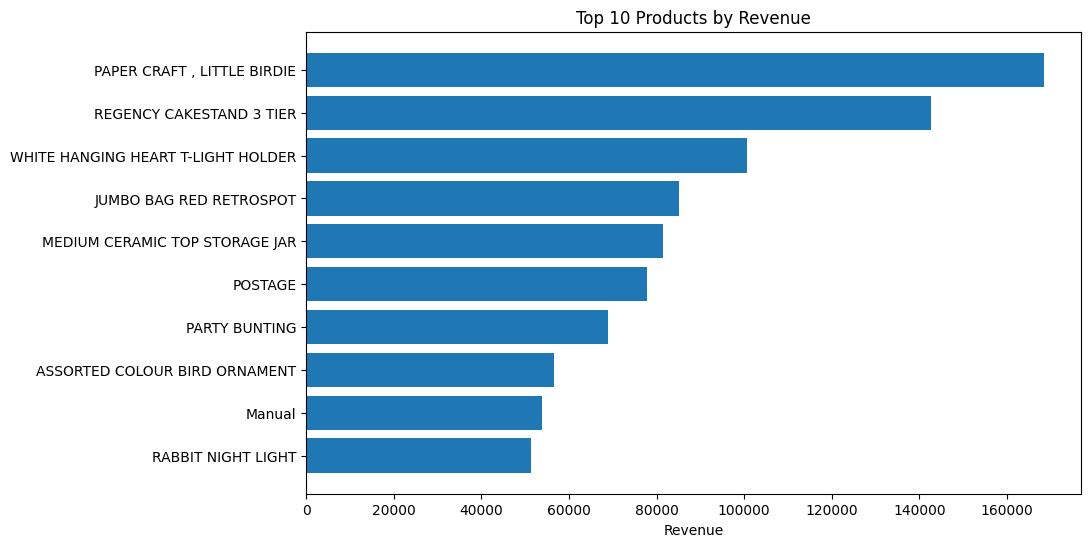

In [16]:
# Top 10 Products by Revenue
top10_revenue = product_summary.sort_values('Revenue', ascending=False).head(10)
plt.figure(figsize=(10,6))
plt.barh(top10_revenue['Description'], top10_revenue['Revenue'])
plt.xlabel('Revenue')
plt.title('Top 10 Products by Revenue')
plt.gca().invert_yaxis()
plt.show()

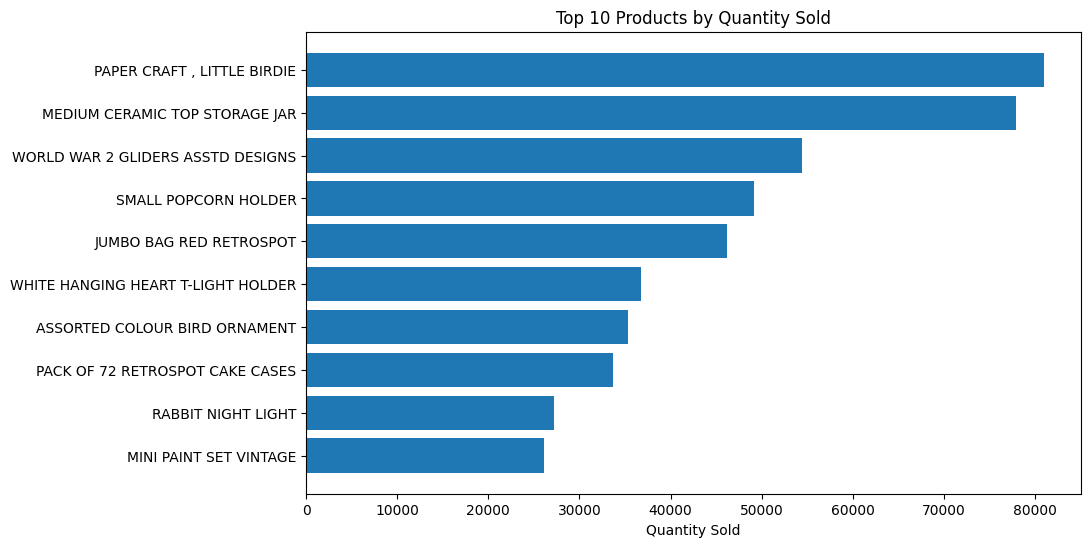

In [17]:
# Top 10 Products by Quantity Sold
top10_quantity = product_summary.sort_values('Quantity', ascending=False).head(10)
plt.figure(figsize=(10,6))
plt.barh(top10_quantity['Description'], top10_quantity['Quantity'])
plt.xlabel('Quantity Sold')
plt.title('Top 10 Products by Quantity Sold')
plt.gca().invert_yaxis()
plt.show()

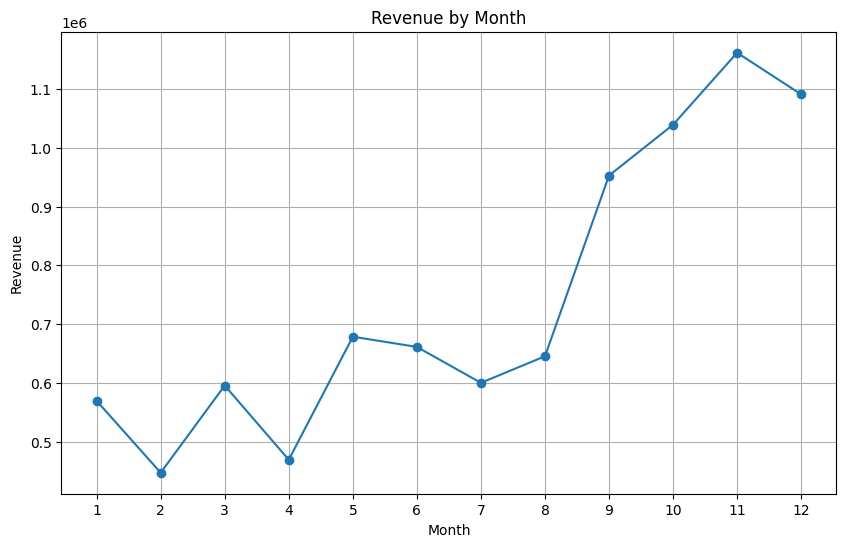

In [22]:
# Revenue by Month
monthly_revenue = df.groupby('Month')['Revenue'].sum().reset_index()
plt.figure(figsize=(10,6))
plt.plot(monthly_revenue['Month'], monthly_revenue['Revenue'], marker='o')
plt.xticks(monthly_revenue['Month'])
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('Revenue by Month')
plt.grid(True)
plt.show()

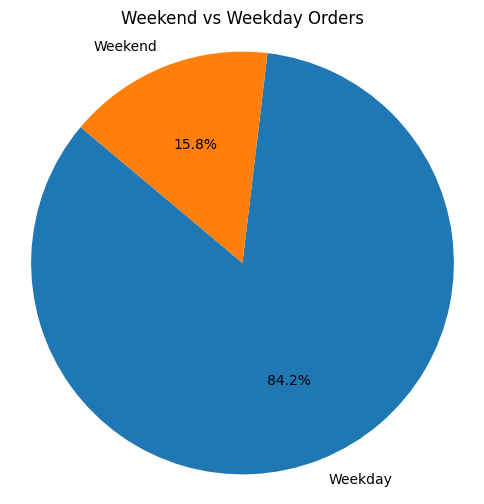

In [24]:
# Weekend vs Weekday Orders
weekend_counts = df['Weekend'].value_counts().rename({True: 'Weekend', False: 'Weekday'})
plt.figure(figsize=(6,6))
plt.pie(weekend_counts, labels=weekend_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Weekend vs Weekday Orders')
plt.axis('equal')
plt.show()

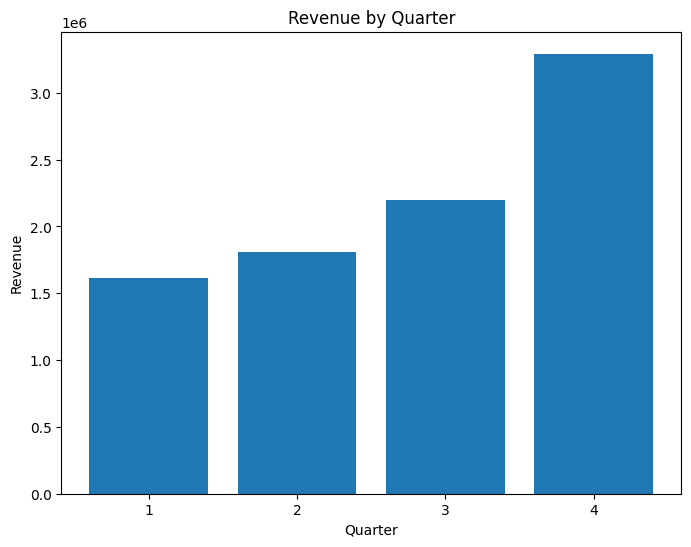

In [26]:
# Quarterly Revenue
quarterly_revenue = df.groupby('Quarter')['Revenue'].sum().reset_index()
plt.figure(figsize=(8,6))
plt.bar(quarterly_revenue['Quarter'], quarterly_revenue['Revenue'])
plt.xlabel('Quarter')
plt.ylabel('Revenue')
plt.title('Revenue by Quarter')
plt.xticks([1,2,3,4])
plt.show()

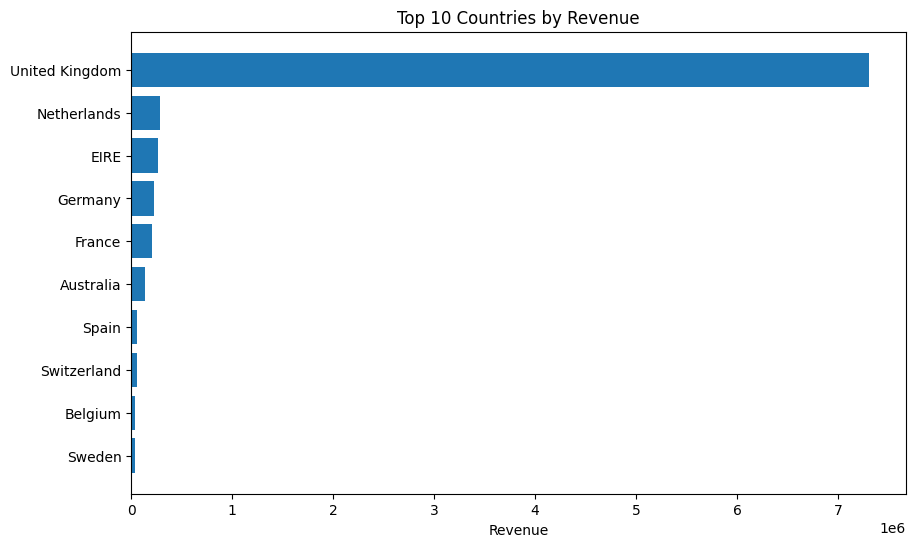

In [38]:
# Top Country by Revenue
country_revenue = df.groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
plt.barh(country_revenue.index, country_revenue.values)
plt.xlabel('Revenue')
plt.title('Top 10 Countries by Revenue')
plt.gca().invert_yaxis()
plt.show()

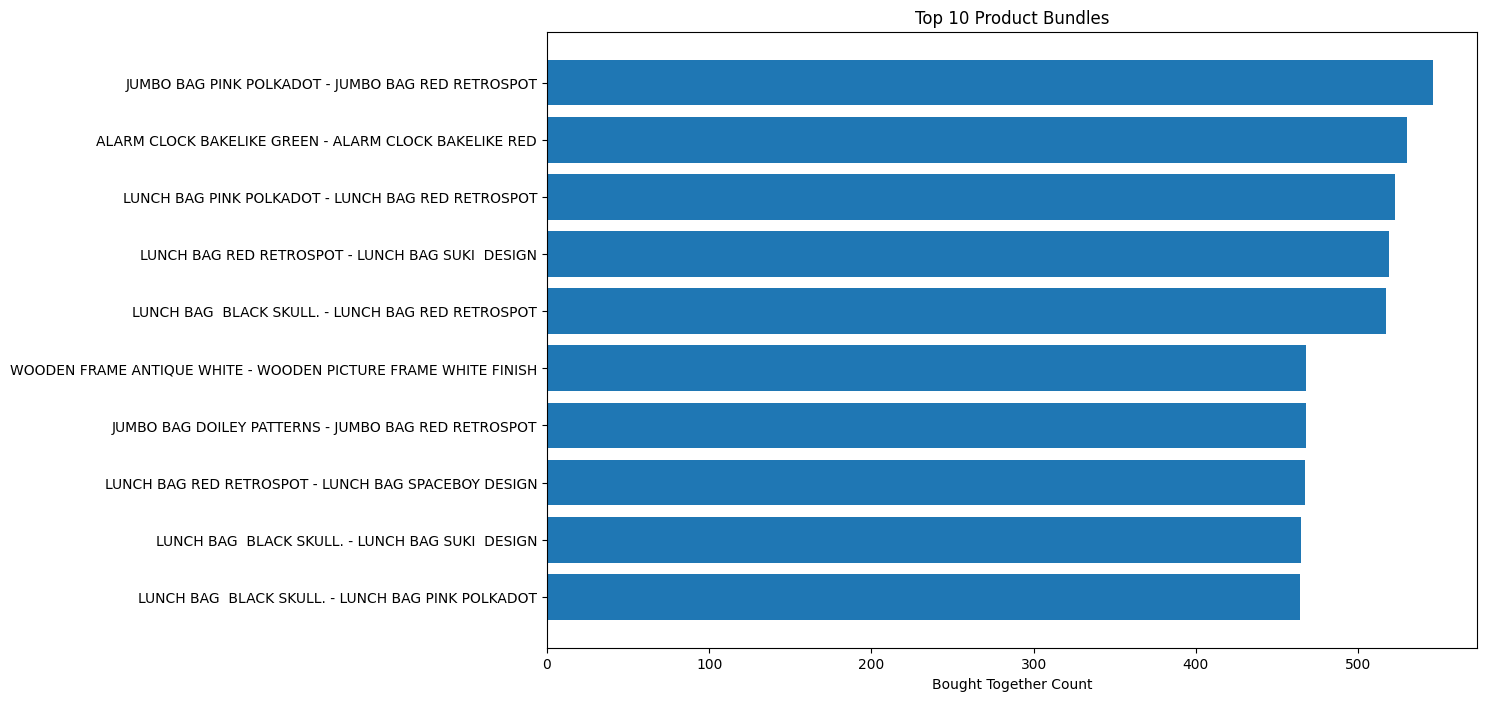

In [27]:
# Top Product Bundles (Pairs) - Market Basket Analysis
plt.figure(figsize=(12,8))
plt.barh(top_pairs_final.head(10)['PAIR'], top_pairs_final.head(10)['BOUGHT_TOGETHER'])
plt.xlabel('Bought Together Count')
plt.title('Top 10 Product Bundles')
plt.gca().invert_yaxis()
plt.show()

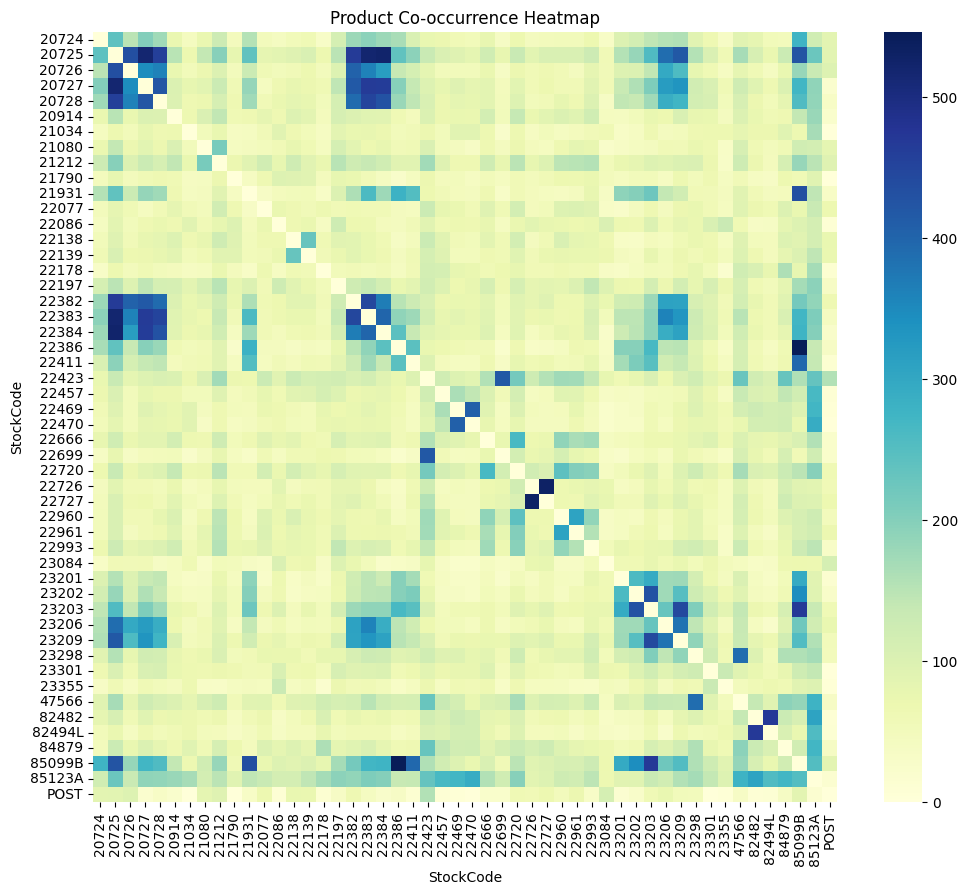

In [32]:
# Heatmap of Product Co-occurrences
co_matrix_for_heatmap = basket.T.dot(basket)
np.fill_diagonal(co_matrix_for_heatmap.values, 0)
plt.figure(figsize=(12,10))
sns.heatmap(co_matrix_for_heatmap, cmap='YlGnBu', cbar=True)
plt.title('Product Co-occurrence Heatmap')
plt.show()

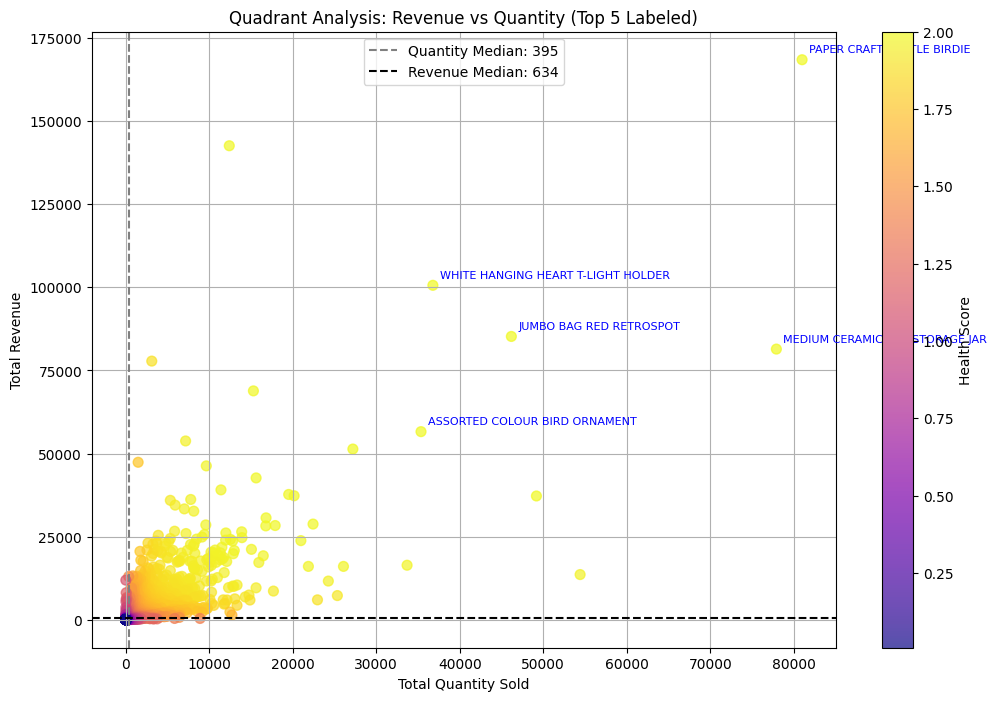

In [41]:
# Quadrant Analysis

quantity_median = product_summary['Quantity'].median()
revenue_median = product_summary['Revenue'].median()
top5_health = product_summary.sort_values('HEALTHSCORE', ascending=False).head(5)

plt.figure(figsize=(12,8))
scatter = plt.scatter(
    product_summary['Quantity'],
    product_summary['Revenue'],
    c=product_summary['HEALTHSCORE'],
    cmap='plasma',
    s=50, alpha=0.7
)
plt.colorbar(scatter, label='Health Score')

plt.axvline(quantity_median, color='grey', linestyle='--', label=f'Quantity Median: {quantity_median:.0f}')
plt.axhline(revenue_median, color='black', linestyle='--', label=f'Revenue Median: {revenue_median:.0f}')
for _, row in top5_health.iterrows():
    plt.annotate(row['Description'], (row['Quantity'], row['Revenue']),
                 textcoords="offset points", xytext=(5,5), ha='left', fontsize=8, color='blue')

plt.xlabel('Total Quantity Sold')
plt.ylabel('Total Revenue')
plt.title('Quadrant Analysis: Revenue vs Quantity (Top 5 Labeled)')
plt.legend()
plt.grid(True)
plt.show()